In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/swapniel99/erav1s8.git
%cd erav1s8/
!git pull
%ls

Cloning into 'erav1s8'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 145 (delta 79), reused 81 (delta 33), pack-reused 0
Receiving objects: 100% (145/145), 3.05 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/erav1s8
Already up to date.
backprop.py  ghostbn.py  README.md         S8.ipynb
datasets/    model.py    requirements.txt  utils.py


In [3]:
from utils import *
set_seed(42)

Device Selected: cuda


In [4]:
from datasets import CIFAR10
batch_size = 32
cifar10 = CIFAR10(batch_size)

100%|██████████| 170498071/170498071 [00:02<00:00, 71712560.93it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


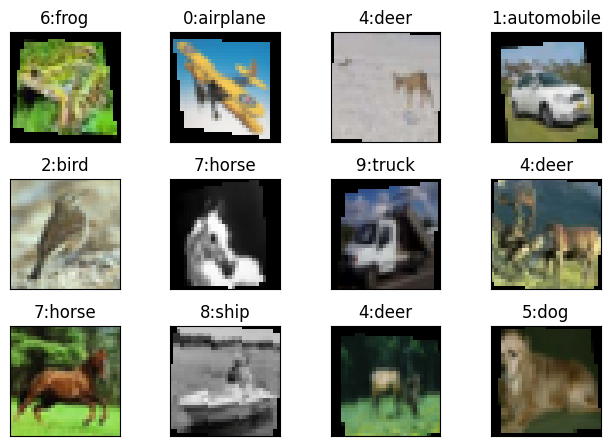

In [5]:
cifar10.show_examples()

In [6]:
from model import GroupNormModel, LayerNormModel, BatchNormModel
from backprop import Experiment

# Experiment 1: Group Normalisation

In [7]:
model1 = GroupNormModel(n_groups=4, skip=True, dropout=0.01)
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
GroupNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [8]:
exp1 = Experiment(model1, cifar10, lr=0.01)
exp1.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.8598, Accuracy=30.38: 100%|██████████| 1563/1563 [00:46<00:00, 33.65it/s]


Test: Average loss: 1.5559, Accuracy: 42.56
Epoch 2


Train: Batch_id=1562, Average Loss=1.5195, Accuracy=44.23: 100%|██████████| 1563/1563 [00:45<00:00, 34.16it/s]


Test: Average loss: 1.3312, Accuracy: 51.46
Epoch 3


Train: Batch_id=1562, Average Loss=1.3447, Accuracy=50.87: 100%|██████████| 1563/1563 [00:46<00:00, 33.44it/s]


Test: Average loss: 1.1816, Accuracy: 56.38
Epoch 4


Train: Batch_id=1562, Average Loss=1.2376, Accuracy=55.13: 100%|██████████| 1563/1563 [00:47<00:00, 33.19it/s]


Test: Average loss: 1.1134, Accuracy: 60.03
Epoch 5


Train: Batch_id=1562, Average Loss=1.1598, Accuracy=58.22: 100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Test: Average loss: 1.0954, Accuracy: 60.75
Epoch 6


Train: Batch_id=1562, Average Loss=1.1067, Accuracy=60.17: 100%|██████████| 1563/1563 [00:46<00:00, 33.75it/s]


Test: Average loss: 0.9680, Accuracy: 65.15
Epoch 7


Train: Batch_id=1562, Average Loss=1.0665, Accuracy=61.89: 100%|██████████| 1563/1563 [00:46<00:00, 33.27it/s]


Test: Average loss: 0.9682, Accuracy: 65.07
Epoch 00007: reducing learning rate of group 0 to 3.0000e-03.
Epoch 8


Train: Batch_id=1562, Average Loss=0.9448, Accuracy=66.13: 100%|██████████| 1563/1563 [00:47<00:00, 32.72it/s]


Test: Average loss: 0.8639, Accuracy: 69.26
Epoch 9


Train: Batch_id=1562, Average Loss=0.9235, Accuracy=67.06: 100%|██████████| 1563/1563 [00:48<00:00, 32.51it/s]


Test: Average loss: 0.8556, Accuracy: 69.56
Epoch 10


Train: Batch_id=1562, Average Loss=0.9106, Accuracy=67.41: 100%|██████████| 1563/1563 [00:47<00:00, 32.96it/s]


Test: Average loss: 0.8621, Accuracy: 69.34
Epoch 00010: reducing learning rate of group 0 to 9.0000e-04.
Epoch 11


Train: Batch_id=1562, Average Loss=0.8700, Accuracy=68.98: 100%|██████████| 1563/1563 [00:47<00:00, 32.97it/s]


Test: Average loss: 0.8215, Accuracy: 70.74
Epoch 12


Train: Batch_id=1562, Average Loss=0.8563, Accuracy=69.60: 100%|██████████| 1563/1563 [00:46<00:00, 33.28it/s]


Test: Average loss: 0.8160, Accuracy: 71.18
Epoch 13


Train: Batch_id=1562, Average Loss=0.8575, Accuracy=69.53: 100%|██████████| 1563/1563 [00:46<00:00, 33.55it/s]


Test: Average loss: 0.8194, Accuracy: 71.27
Epoch 00013: reducing learning rate of group 0 to 2.7000e-04.
Epoch 14


Train: Batch_id=1562, Average Loss=0.8414, Accuracy=70.18: 100%|██████████| 1563/1563 [00:46<00:00, 33.73it/s]


Test: Average loss: 0.7985, Accuracy: 72.09
Epoch 15


Train: Batch_id=1562, Average Loss=0.8401, Accuracy=70.22: 100%|██████████| 1563/1563 [00:46<00:00, 33.69it/s]


Test: Average loss: 0.7930, Accuracy: 72.37
Epoch 16


Train: Batch_id=1562, Average Loss=0.8335, Accuracy=70.36: 100%|██████████| 1563/1563 [00:46<00:00, 33.63it/s]


Test: Average loss: 0.7915, Accuracy: 72.27
Epoch 17


Train: Batch_id=1562, Average Loss=0.8328, Accuracy=70.50: 100%|██████████| 1563/1563 [00:47<00:00, 33.20it/s]


Test: Average loss: 0.7889, Accuracy: 72.46
Epoch 18


Train: Batch_id=1562, Average Loss=0.8351, Accuracy=70.31: 100%|██████████| 1563/1563 [00:46<00:00, 33.26it/s]


Test: Average loss: 0.7825, Accuracy: 72.84
Epoch 19


Train: Batch_id=1562, Average Loss=0.8296, Accuracy=70.40: 100%|██████████| 1563/1563 [00:47<00:00, 32.89it/s]


Test: Average loss: 0.7870, Accuracy: 72.62
Epoch 00019: reducing learning rate of group 0 to 8.1000e-05.
Epoch 20


Train: Batch_id=1562, Average Loss=0.8247, Accuracy=70.81: 100%|██████████| 1563/1563 [00:47<00:00, 33.09it/s]


Test: Average loss: 0.7832, Accuracy: 72.68
Epoch 00020: reducing learning rate of group 0 to 2.4300e-05.


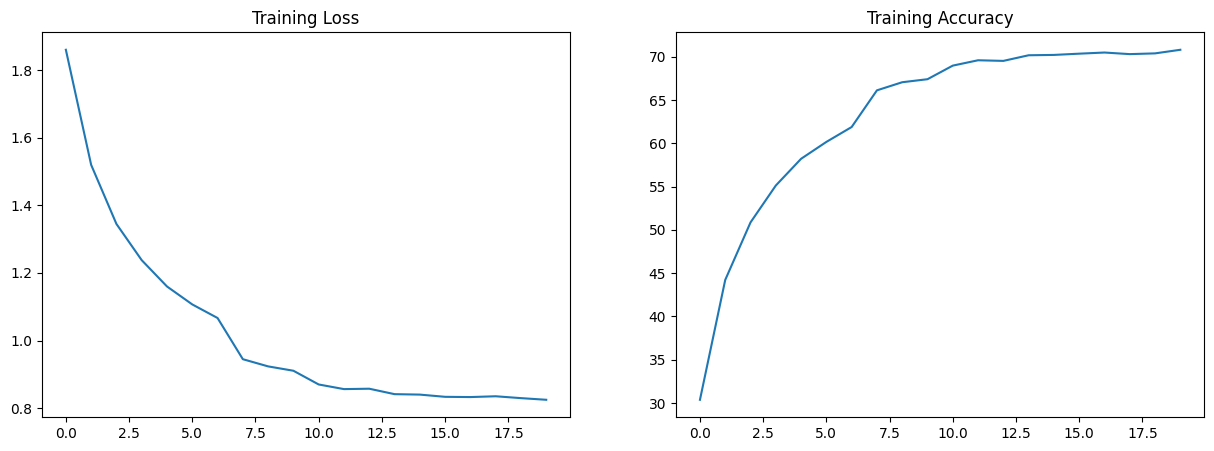

In [9]:
exp1.train.plot_stats()

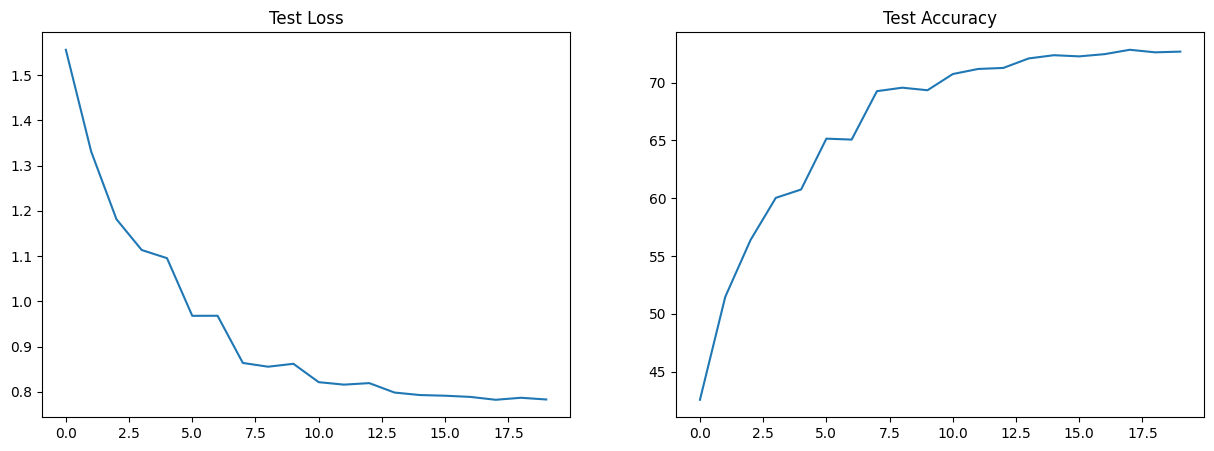

In [10]:
exp1.test.plot_stats()

Test: Average loss: 0.7832, Accuracy: 72.68


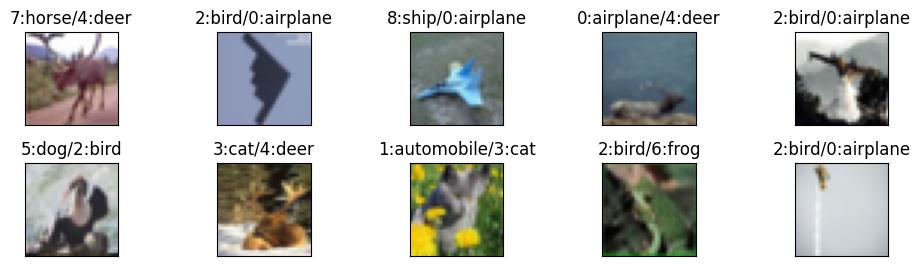

In [11]:
exp1.show_incorrect()

# Experiment 2: Layer Normalisation

In [12]:
model2 = LayerNormModel(skip=True, dropout=0.01)
model2.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
LayerNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─GroupNorm: 3-2               [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [13]:
exp2 = Experiment(model2, cifar10)
exp2.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.9216, Accuracy=28.39: 100%|██████████| 1563/1563 [00:46<00:00, 33.70it/s]


Test: Average loss: 1.6108, Accuracy: 40.88
Epoch 2


Train: Batch_id=1562, Average Loss=1.5957, Accuracy=41.09: 100%|██████████| 1563/1563 [00:46<00:00, 33.48it/s]


Test: Average loss: 1.4279, Accuracy: 47.14
Epoch 3


Train: Batch_id=1562, Average Loss=1.4177, Accuracy=48.10: 100%|██████████| 1563/1563 [00:47<00:00, 32.77it/s]


Test: Average loss: 1.2883, Accuracy: 51.85
Epoch 4


Train: Batch_id=1562, Average Loss=1.3019, Accuracy=52.64: 100%|██████████| 1563/1563 [00:47<00:00, 33.00it/s]


Test: Average loss: 1.2401, Accuracy: 54.90
Epoch 5


Train: Batch_id=1562, Average Loss=1.2261, Accuracy=55.48: 100%|██████████| 1563/1563 [00:47<00:00, 32.99it/s]


Test: Average loss: 1.1083, Accuracy: 59.95
Epoch 6


Train: Batch_id=1562, Average Loss=1.1727, Accuracy=57.94: 100%|██████████| 1563/1563 [00:47<00:00, 32.83it/s]


Test: Average loss: 1.1642, Accuracy: 58.44
Epoch 00006: reducing learning rate of group 0 to 3.0000e-03.
Epoch 7


Train: Batch_id=1562, Average Loss=1.0511, Accuracy=62.57: 100%|██████████| 1563/1563 [00:47<00:00, 33.19it/s]


Test: Average loss: 0.9848, Accuracy: 65.45
Epoch 8


Train: Batch_id=1562, Average Loss=1.0296, Accuracy=63.21: 100%|██████████| 1563/1563 [00:46<00:00, 33.35it/s]


Test: Average loss: 0.9837, Accuracy: 65.64
Epoch 9


Train: Batch_id=1562, Average Loss=1.0118, Accuracy=63.85: 100%|██████████| 1563/1563 [00:46<00:00, 33.61it/s]


Test: Average loss: 0.9570, Accuracy: 66.25
Epoch 10


Train: Batch_id=1562, Average Loss=1.0000, Accuracy=64.29: 100%|██████████| 1563/1563 [00:45<00:00, 34.13it/s]


Test: Average loss: 0.9469, Accuracy: 66.59
Epoch 11


Train: Batch_id=1562, Average Loss=0.9837, Accuracy=64.77: 100%|██████████| 1563/1563 [00:45<00:00, 34.18it/s]


Test: Average loss: 0.9174, Accuracy: 67.24
Epoch 12


Train: Batch_id=1562, Average Loss=0.9716, Accuracy=65.54: 100%|██████████| 1563/1563 [00:46<00:00, 33.71it/s]


Test: Average loss: 0.9249, Accuracy: 67.14
Epoch 00012: reducing learning rate of group 0 to 9.0000e-04.
Epoch 13


Train: Batch_id=1562, Average Loss=0.9202, Accuracy=67.13: 100%|██████████| 1563/1563 [00:46<00:00, 33.61it/s]


Test: Average loss: 0.8698, Accuracy: 69.41
Epoch 14


Train: Batch_id=1562, Average Loss=0.9109, Accuracy=67.42: 100%|██████████| 1563/1563 [00:46<00:00, 33.45it/s]


Test: Average loss: 0.8786, Accuracy: 69.11
Epoch 00014: reducing learning rate of group 0 to 2.7000e-04.
Epoch 15


Train: Batch_id=1562, Average Loss=0.8995, Accuracy=68.08: 100%|██████████| 1563/1563 [00:46<00:00, 33.72it/s]


Test: Average loss: 0.8602, Accuracy: 69.99
Epoch 16


Train: Batch_id=1562, Average Loss=0.8937, Accuracy=68.10: 100%|██████████| 1563/1563 [00:45<00:00, 34.13it/s]


Test: Average loss: 0.8526, Accuracy: 70.24
Epoch 17


Train: Batch_id=1562, Average Loss=0.8877, Accuracy=68.37: 100%|██████████| 1563/1563 [00:45<00:00, 34.19it/s]


Test: Average loss: 0.8506, Accuracy: 70.19
Epoch 18


Train: Batch_id=1562, Average Loss=0.8890, Accuracy=68.44: 100%|██████████| 1563/1563 [00:46<00:00, 33.78it/s]


Test: Average loss: 0.8502, Accuracy: 70.36
Epoch 19


Train: Batch_id=1562, Average Loss=0.8861, Accuracy=68.60: 100%|██████████| 1563/1563 [00:46<00:00, 33.46it/s]


Test: Average loss: 0.8467, Accuracy: 70.30
Epoch 20


Train: Batch_id=1562, Average Loss=0.8832, Accuracy=68.57: 100%|██████████| 1563/1563 [00:46<00:00, 33.43it/s]


Test: Average loss: 0.8434, Accuracy: 70.58


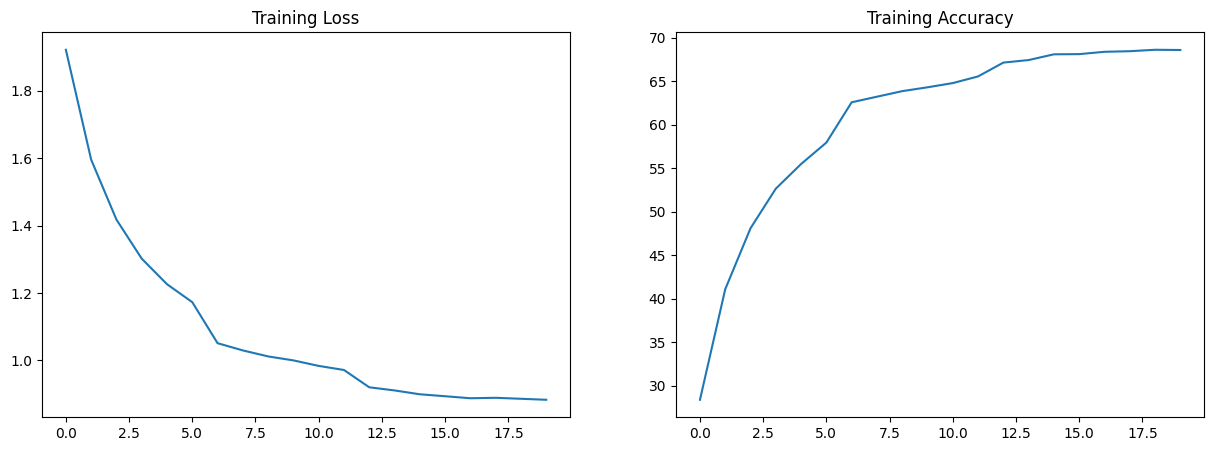

In [14]:
exp2.train.plot_stats()

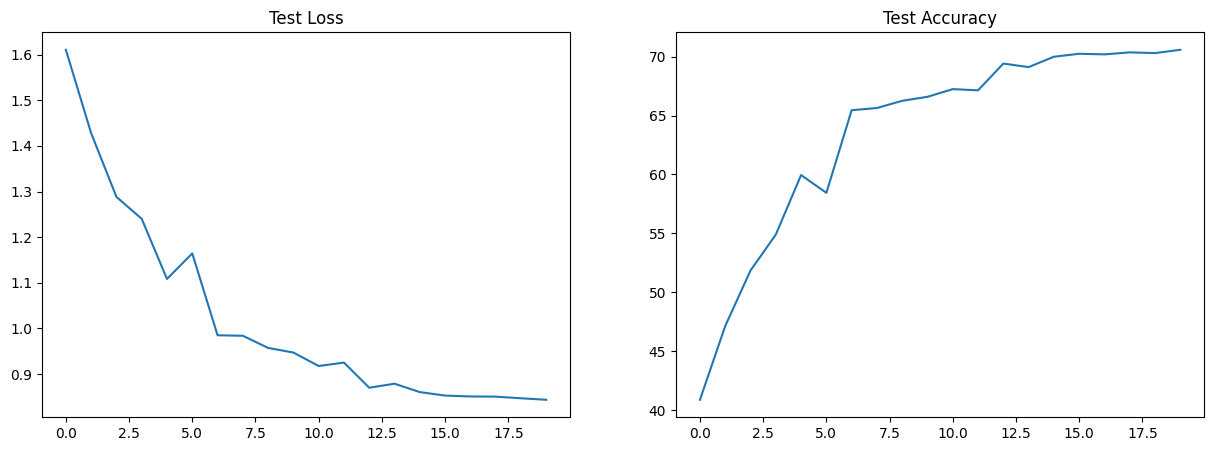

In [15]:
exp2.test.plot_stats()

Test: Average loss: 0.8434, Accuracy: 70.58


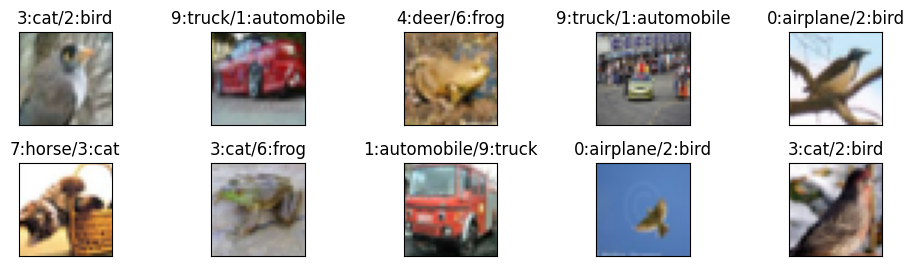

In [16]:
exp2.show_incorrect()

# Experiment 3: Batch Normalisation

In [17]:
model3 = BatchNormModel(skip=True, dropout=0.01)
model3.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
BatchNormModel                           [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─ConvLayer: 2-1                    [32, 3, 32, 32]           [32, 16, 30, 30]          --                             --
│    │    └─Conv2d: 3-1                  [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.90%
│    │    └─BatchNorm2d: 3-2             [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    │    └─ReLU: 3-3                    [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    │    └─Dropout: 3-4                 [32, 16, 30, 30]          [32, 16, 30, 30]          --                

In [18]:
exp3 = Experiment(model3, cifar10)
exp3.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.5782, Accuracy=41.67: 100%|██████████| 1563/1563 [00:46<00:00, 33.88it/s]


Test: Average loss: 1.2540, Accuracy: 53.75
Epoch 2


Train: Batch_id=1562, Average Loss=1.2681, Accuracy=54.31: 100%|██████████| 1563/1563 [00:45<00:00, 34.10it/s]


Test: Average loss: 1.1763, Accuracy: 57.52
Epoch 3


Train: Batch_id=1562, Average Loss=1.1360, Accuracy=59.56: 100%|██████████| 1563/1563 [00:45<00:00, 34.26it/s]


Test: Average loss: 1.0187, Accuracy: 63.78
Epoch 4


Train: Batch_id=1562, Average Loss=1.0500, Accuracy=62.71: 100%|██████████| 1563/1563 [00:44<00:00, 35.22it/s]


Test: Average loss: 0.9021, Accuracy: 67.50
Epoch 5


Train: Batch_id=1562, Average Loss=0.9889, Accuracy=64.96: 100%|██████████| 1563/1563 [00:44<00:00, 35.07it/s]


Test: Average loss: 0.8440, Accuracy: 70.09
Epoch 6


Train: Batch_id=1562, Average Loss=0.9447, Accuracy=66.74: 100%|██████████| 1563/1563 [00:45<00:00, 34.29it/s]


Test: Average loss: 0.7809, Accuracy: 72.35
Epoch 7


Train: Batch_id=1562, Average Loss=0.9087, Accuracy=67.97: 100%|██████████| 1563/1563 [00:45<00:00, 34.24it/s]


Test: Average loss: 0.7647, Accuracy: 72.93
Epoch 8


Train: Batch_id=1562, Average Loss=0.8829, Accuracy=69.12: 100%|██████████| 1563/1563 [00:44<00:00, 35.18it/s]


Test: Average loss: 0.7660, Accuracy: 72.91
Epoch 00008: reducing learning rate of group 0 to 3.0000e-03.
Epoch 9


Train: Batch_id=1562, Average Loss=0.8023, Accuracy=71.98: 100%|██████████| 1563/1563 [00:44<00:00, 35.06it/s]


Test: Average loss: 0.6841, Accuracy: 75.59
Epoch 10


Train: Batch_id=1562, Average Loss=0.7853, Accuracy=72.49: 100%|██████████| 1563/1563 [00:45<00:00, 34.44it/s]


Test: Average loss: 0.6660, Accuracy: 76.70
Epoch 11


Train: Batch_id=1562, Average Loss=0.7696, Accuracy=73.09: 100%|██████████| 1563/1563 [00:45<00:00, 34.10it/s]


Test: Average loss: 0.6603, Accuracy: 76.65
Epoch 12


Train: Batch_id=1562, Average Loss=0.7611, Accuracy=73.38: 100%|██████████| 1563/1563 [00:44<00:00, 35.11it/s]


Test: Average loss: 0.6622, Accuracy: 76.49
Epoch 00012: reducing learning rate of group 0 to 9.0000e-04.
Epoch 13


Train: Batch_id=1562, Average Loss=0.7330, Accuracy=74.37: 100%|██████████| 1563/1563 [00:44<00:00, 35.21it/s]


Test: Average loss: 0.6360, Accuracy: 77.45
Epoch 14


Train: Batch_id=1562, Average Loss=0.7304, Accuracy=74.75: 100%|██████████| 1563/1563 [00:45<00:00, 34.42it/s]


Test: Average loss: 0.6293, Accuracy: 77.51
Epoch 15


Train: Batch_id=1562, Average Loss=0.7262, Accuracy=74.56: 100%|██████████| 1563/1563 [00:45<00:00, 34.09it/s]


Test: Average loss: 0.6297, Accuracy: 77.66
Epoch 00015: reducing learning rate of group 0 to 2.7000e-04.
Epoch 16


Train: Batch_id=1562, Average Loss=0.7219, Accuracy=74.92: 100%|██████████| 1563/1563 [00:45<00:00, 34.52it/s]


Test: Average loss: 0.6255, Accuracy: 77.91
Epoch 17


Train: Batch_id=1562, Average Loss=0.7147, Accuracy=74.98: 100%|██████████| 1563/1563 [00:44<00:00, 34.79it/s]


Test: Average loss: 0.6249, Accuracy: 77.75
Epoch 18


Train: Batch_id=1562, Average Loss=0.7177, Accuracy=75.09: 100%|██████████| 1563/1563 [00:44<00:00, 34.93it/s]


Test: Average loss: 0.6257, Accuracy: 77.94
Epoch 00018: reducing learning rate of group 0 to 8.1000e-05.
Epoch 19


Train: Batch_id=1562, Average Loss=0.7127, Accuracy=75.22: 100%|██████████| 1563/1563 [00:45<00:00, 34.29it/s]


Test: Average loss: 0.6221, Accuracy: 77.92
Epoch 20


Train: Batch_id=1562, Average Loss=0.7152, Accuracy=74.79: 100%|██████████| 1563/1563 [00:45<00:00, 34.54it/s]


Test: Average loss: 0.6189, Accuracy: 78.13


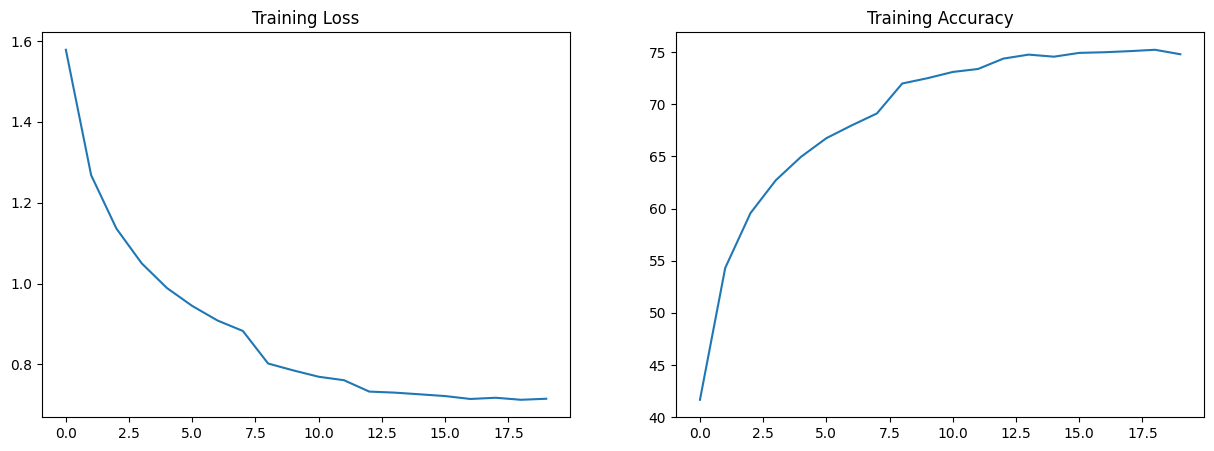

In [19]:
exp3.train.plot_stats()

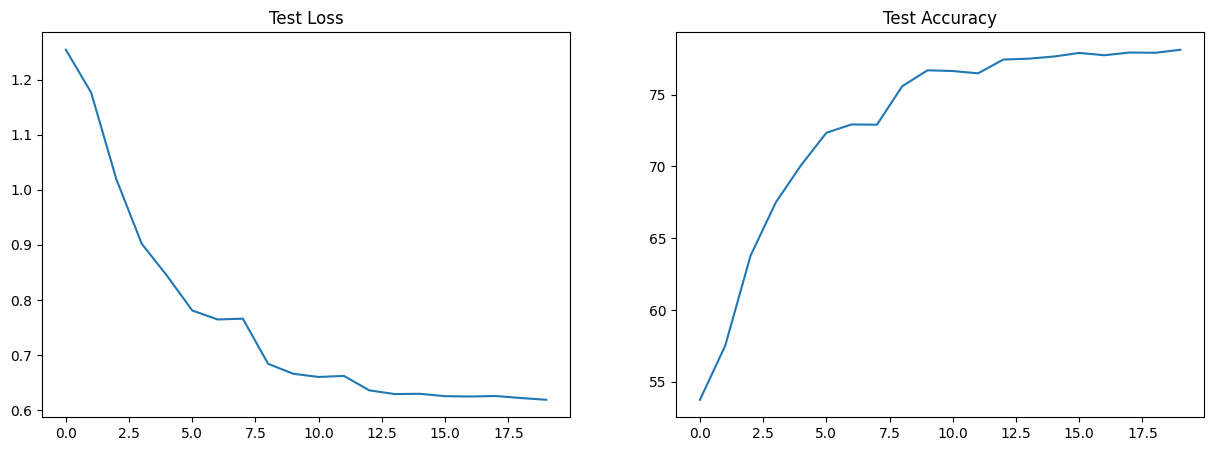

In [20]:
exp3.test.plot_stats()

Test: Average loss: 0.6189, Accuracy: 78.13


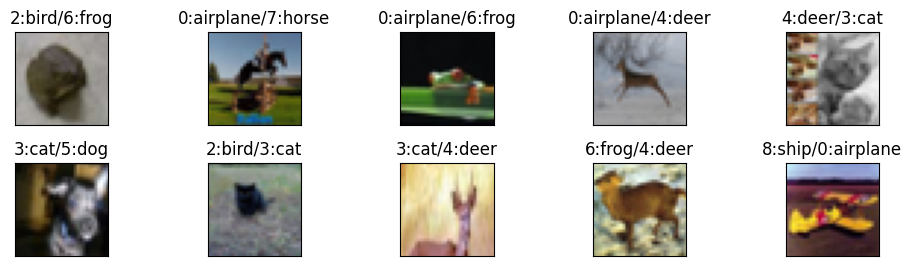

In [21]:
exp3.show_incorrect()